In [1]:
### Bu notebook tek bir gün için 15 dakikalık zaman dilimleri alıyor (96 interval/gün)
### Her müşteri için o günün elektrik tüketim profili
### Saatlik değişimler, peak zamanlar vb. hesaplıyor.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
import seaborn as sns

In [3]:
def load_and_process_data(file_path):
    """
    Load and process a load profile data file into a clean DataFrame.
    """
    # Extract day number from filename
    file_day = int(os.path.basename(file_path).split('_')[-1].split('.')[0])
    
    # Read the file content
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Find format line to get headers
    format_line = next((line for line in lines if line.startswith('FORMAT=')), None)
    if not format_line:
        raise ValueError("Could not find FORMAT= line in the file")
    
    # Extract headers
    headers = format_line.strip().split('=')[1].split(',')
    
    # Find the starting point for data (first line with 'res_')
    start_index = next((i for i, line in enumerate(lines) if 'res_' in line), 0)
    
    # Process the data
    data = []
    for line in lines[start_index:]:
        if not line.strip():
            continue
        
        parts = line.strip().split(',')
        if len(parts) < 12:  # Minimum required fields
            continue
        
        # Extract metadata
        customer_id = parts[0]
        profile_type = parts[1]
        
        # Extract load values (starting from the 11th column)
        values = [float(val) if val.strip() and val != 'None' else np.nan 
                  for val in parts[11:] if val.strip()]
        
        # Create a row for each 15-minute interval
        for i, value in enumerate(values):
            # Calculate time information
            hour = (i * 15) // 60
            minute = (i * 15) % 60
            time_str = f"{hour:02d}:{minute:02d}"
            
            # Create data row
            data_row = {
                'customer_id': customer_id,
                'profile_type': profile_type,
                'day': file_day,
                'timestamp': time_str,
                'hour': hour,
                'minute': minute,
                'interval_idx': i,
                'load_percentage': value
            }
            data.append(data_row)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

In [4]:
def analyze_profile(df, customer_id=None):
    """
    Analyze and visualize the load profile for a specific customer or all customers.
    """
    # If no customer specified, use the first one
    if customer_id is None:
        customer_id = df['customer_id'].iloc[0]
    
    # Filter for the specified customer
    customer_df = df[df['customer_id'] == customer_id]
    
    # Summary statistics
    summary = customer_df['load_percentage'].describe()
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Create the main load profile plot
    ax.plot(range(len(customer_df)), customer_df['load_percentage'], 
            marker='o', linestyle='-', markersize=4, color='blue')
    
    # Add grid and labels
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(f"Load Profile for Customer {customer_id} - Day {customer_df['day'].iloc[0]}", fontsize=16)
    ax.set_xlabel('Time of Day', fontsize=12)
    ax.set_ylabel('Load Percentage (%)', fontsize=12)
    
    # Set x-axis ticks to show hours
    hour_indices = [i for i, row in customer_df.iterrows() if row['minute'] == 0]
    hour_labels = [f"{h:02d}:00" for h in range(24)]
    ax.set_xticks(hour_indices)
    ax.set_xticklabels(hour_labels, rotation=45)
    
    # Add horizontal lines for average and peak
    ax.axhline(y=summary['mean'], color='r', linestyle='--', 
               label=f'Average: {summary["mean"]:.2f}%')
    ax.axhline(y=summary['max'], color='g', linestyle='--', 
               label=f'Peak: {summary["max"]:.2f}%')
    
    # Add annotations for peak times
    peak_idx = customer_df['load_percentage'].idxmax()
    peak_time = customer_df.loc[peak_idx, 'timestamp']
    peak_value = customer_df.loc[peak_idx, 'load_percentage']
    ax.annotate(f'Peak: {peak_value:.2f}% at {peak_time}', 
                xy=(peak_idx, peak_value),
                xytext=(peak_idx, peak_value + 5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    # Add legend
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'customer_{customer_id}_day_{customer_df["day"].iloc[0]}_profile.png', dpi=300)
    
    return fig, summary


In [5]:
def analyze_all_customers(df, max_customers=10):
    """
    Compare load profiles across different customers.
    """
    # Get unique customers (up to max_customers)
    customers = df['customer_id'].unique()[:max_customers]
    day = df['day'].iloc[0]
    
    # Create figure for comparison
    plt.figure(figsize=(15, 10))
    
    # Plot each customer's profile
    for customer in customers:
        customer_df = df[df['customer_id'] == customer]
        plt.plot(customer_df['interval_idx'], customer_df['load_percentage'], 
                 label=customer, alpha=0.7)
    
    # Set up the plot
    plt.title(f"Comparison of {len(customers)} Customer Load Profiles - Day {day}")
    plt.xlabel("Time Interval (15-minute periods)")
    plt.ylabel("Load Percentage (%)")
    plt.grid(True)
    
    # Set x-axis ticks to show hours
    hour_ticks = list(range(0, 97, 4))  # Every hour (4 intervals)
    hour_labels = [f"{h//4:02d}:00" for h in hour_ticks]
    plt.xticks(hour_ticks, hour_labels, rotation=45)
    
    # Add legend in a separate box
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'customer_comparison_day_{day}.png', dpi=300)
    
    return plt.gcf()

Total records: 85248
Unique customers: 888
Day: 1
Time periods: 96 (15-minute intervals)

Sample data:
  customer_id  profile_type  day timestamp  hour  minute  interval_idx  \
0   res_18572  CUSTOMERTYPE    1     00:00     0       0             0   
1   res_18572  CUSTOMERTYPE    1     00:15     0      15             1   
2   res_18572  CUSTOMERTYPE    1     00:30     0      30             2   
3   res_18572  CUSTOMERTYPE    1     00:45     0      45             3   
4   res_18572  CUSTOMERTYPE    1     01:00     1       0             4   

   load_percentage  
0          10.4441  
1          10.4441  
2          10.4441  
3          10.4441  
4          10.4215  

Customer res_18572 load profile statistics:
count    96.000000
mean     29.281978
std      14.824876
min       9.655900
25%      19.179700
50%      22.485250
75%      38.877525
max      68.049200
Name: load_percentage, dtype: float64
Saved profile visualization to '/home/han/projects/data-project-1.2/1-research/findings/cus

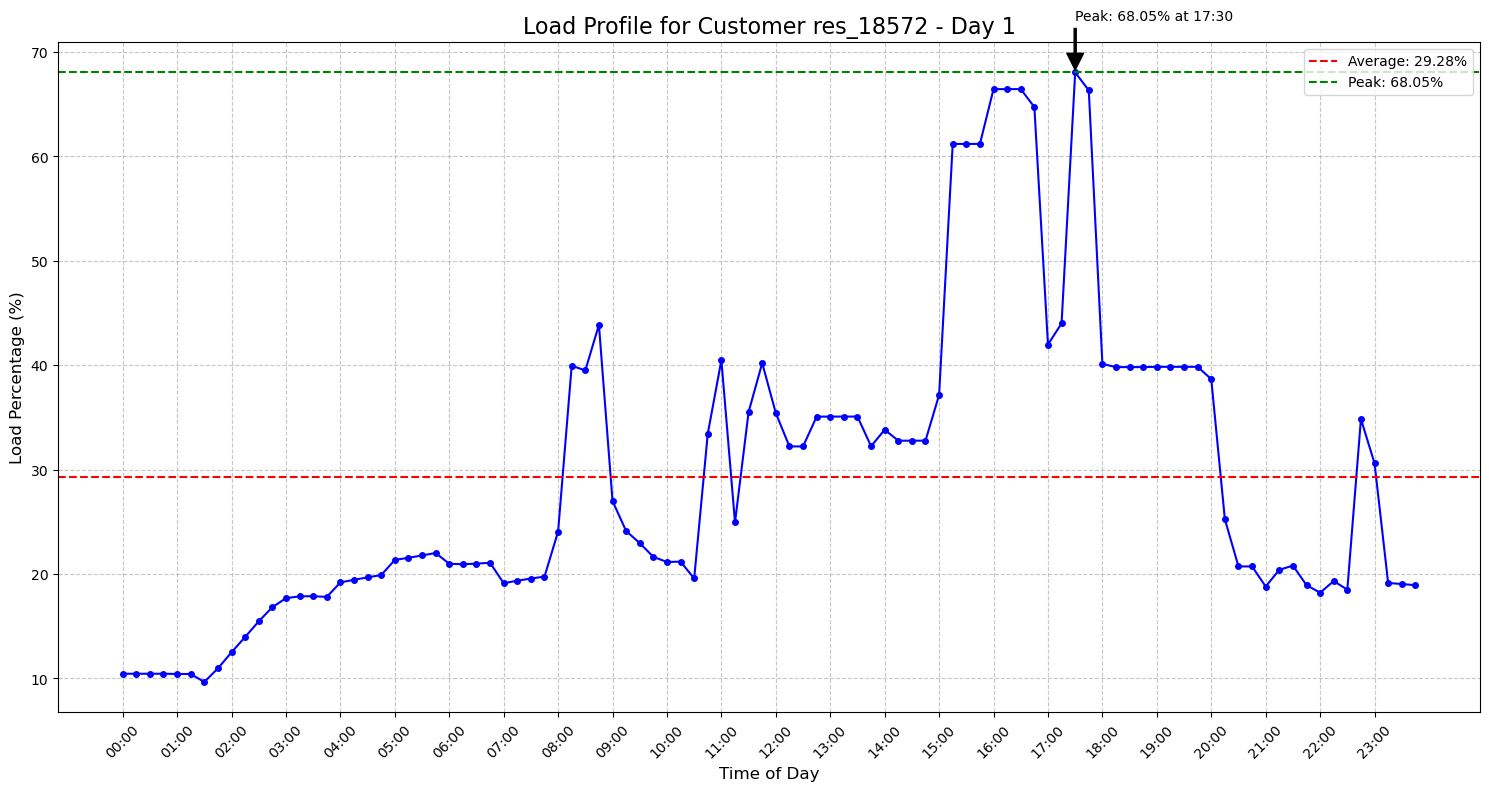

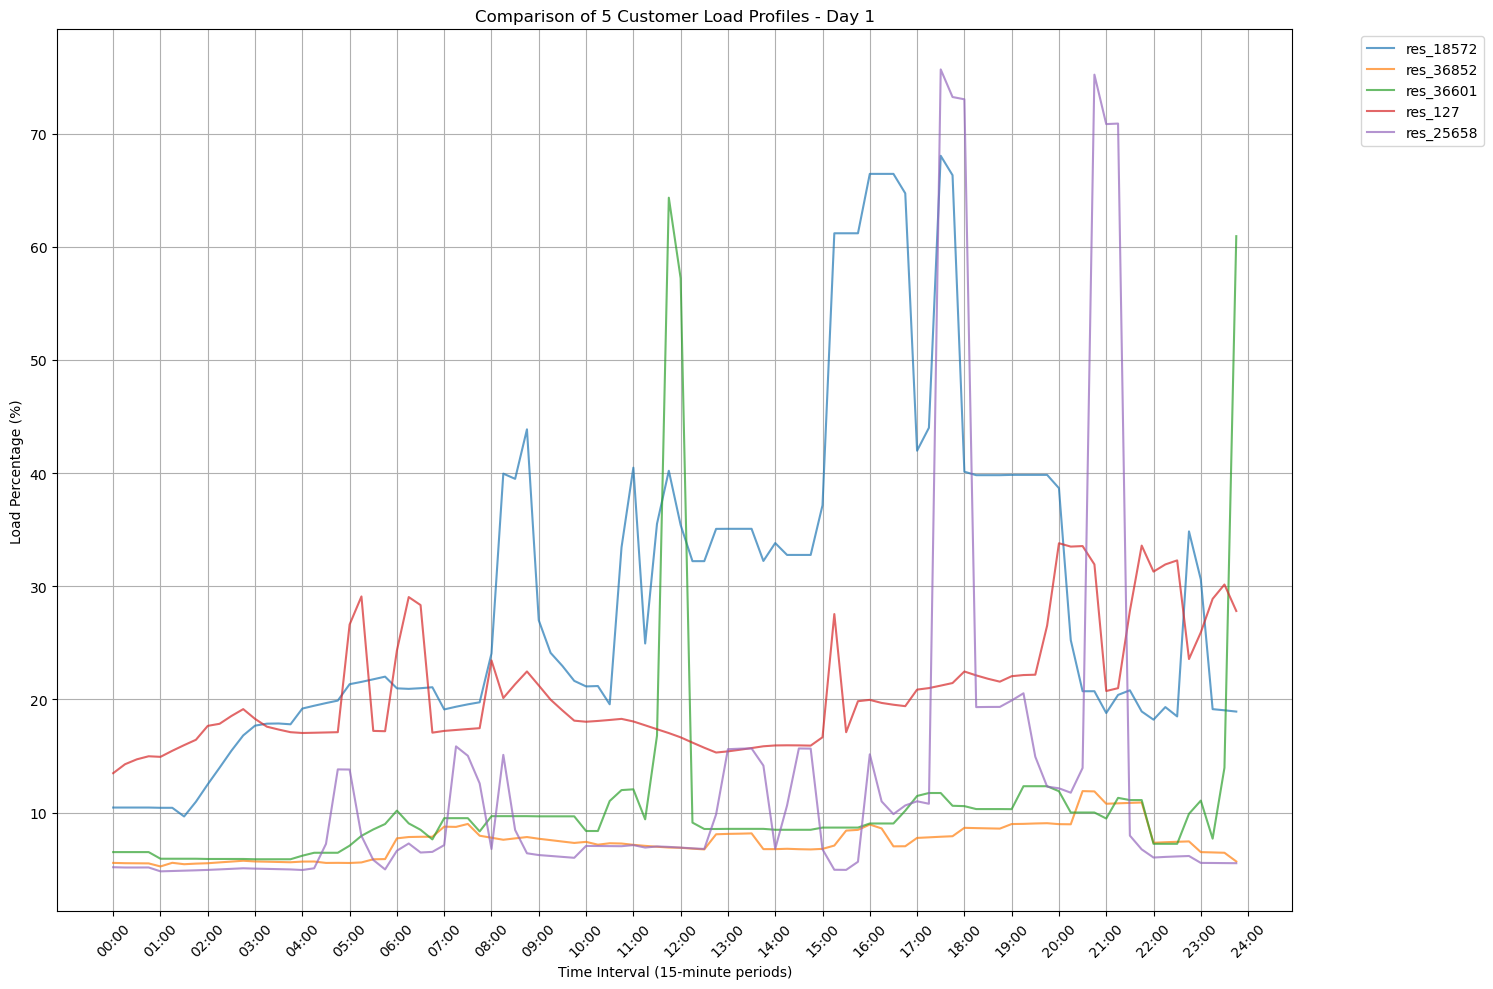

In [11]:
#main

if __name__ == "__main__":
    # Dosya yolu
    file_path = "/home/han/data/smart-ds/2016/AUS/P1R/load_timeseries/cyme_load_timeseries_day_1.txt"
    
    # Çıktı dizini
    output_dir = "/home/han/projects/data-project-1.2/1-research/findings"
    os.makedirs(output_dir, exist_ok=True)  # Klasör yoksa oluştur
    
    # Veriyi yükle ve işle
    df = load_and_process_data(file_path)
    
    # Temel istatistikleri yazdır
    print(f"Total records: {len(df)}")
    print(f"Unique customers: {df['customer_id'].nunique()}")
    print(f"Day: {df['day'].iloc[0]}")
    print(f"Time periods: {df['interval_idx'].nunique()} (15-minute intervals)")
    
    # İlk birkaç satırı göster
    print("\nSample data:")
    print(df.head())
    
    # Tek bir müşterinin profili analizi
    first_customer = df['customer_id'].iloc[0]
    fig, summary = analyze_profile(df, first_customer)
    
    profile_path = f"{output_dir}/customer_{first_customer}_day_{df['day'].iloc[0]}_profile.png"
    plt.savefig(profile_path)
    print(f"\nCustomer {first_customer} load profile statistics:")
    print(summary)
    print(f"Saved profile visualization to '{profile_path}'")
    
    # Birden fazla müşteri karşılaştırması
    compare_fig = analyze_all_customers(df, max_customers=5)
    
    comparison_path = f"{output_dir}/customer_comparison_day_{df['day'].iloc[0]}.png"
    plt.savefig(comparison_path)
    print(f"\nSaved customer comparison to '{comparison_path}'")
    
    plt.show()
